<a href="https://colab.research.google.com/github/elkinsleah/Bird-Species-Classification/blob/main/BirdClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**READ ME:**

TITLE: Bird Species Classification (C964 WGU Computer Science Capstone)

PURPOSE: Bird species image classification web application. This application can identify 70 species of birds with an accuracy up to 43%.

DIRECTIONS: Click the link below to access the web application on HuggingFace. All other information for this project including the code, data, and visuals of data are included below.

> https://huggingface.co/spaces/elki15/Bird_Species_Classification

ENVIRONMENT:

> Programming language: Python version 3.10.12

> IDE: Google Colab

> API: Gradio.app

> The application is permanently hosted in HuggingFace public space

Date: September 14, 2023

AUTHOR: Leah Elkins, student ID #008983922


# Mount Google Drive and Import Libraries

Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [ ]:
# Import the necessary libraries
!pip install tensorflow
!pip install gradio

import tensorflow as tf
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import glob
import cv2

from google.colab.patches import cv2_imshow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Data

## Explore data

Download dataset

In [ ]:
# Bird species image dataset downloaded to Google Drive
# Link to original dataset: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
# Note: The link is to the original dataset, this application used a subset of the dataset

Explore the data (training, validation, and testing)

In [ ]:
# Set the path to the CSV file with the metadata
csv_path = '/content/drive/MyDrive/Colab_Notebooks/data/birds/birds.csv'

# Load the CSV file with the metadata
metadata = pd.read_csv(csv_path)
print(metadata)

                         filepaths           labels data set
0      train/ALPINE CHOUGH/001.jpg    ALPINE CHOUGH    train
1      train/ALPINE CHOUGH/002.jpg    ALPINE CHOUGH    train
2      train/ALPINE CHOUGH/003.jpg    ALPINE CHOUGH    train
3      train/ALPINE CHOUGH/018.jpg    ALPINE CHOUGH    train
4      train/ALPINE CHOUGH/009.jpg    ALPINE CHOUGH    train
...                            ...              ...      ...
11829  valid/AMERICAN DIPPER/4.jpg  AMERICAN DIPPER    valid
11830  valid/AMERICAN DIPPER/5.jpg  AMERICAN DIPPER    valid
11831  valid/AMERICAN DIPPER/1.jpg  AMERICAN DIPPER    valid
11832  valid/AMERICAN DIPPER/2.jpg  AMERICAN DIPPER    valid
11833  valid/AMERICAN DIPPER/3.jpg  AMERICAN DIPPER    valid

[11834 rows x 3 columns]


In [ ]:
# Calculate the number of classes within the dataset (bird species)
num_classes = len(metadata['labels'].unique())
print('Number of classes: ',num_classes)

Number of classes:  70


In [ ]:
# Check the labels (bird species) for discrepancies
print(metadata['labels'].unique())

['ALPINE CHOUGH' 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET'
 'AMERICAN BITTERN' 'AMERICAN FLAMINGO' 'AMERICAN GOLDFINCH'
 'AMERICAN KESTREL' 'AMERICAN PIPIT' 'AMERICAN REDSTART' 'AMERICAN ROBIN'
 'AMERICAN WIGEON' 'AMETHYST WOODSTAR' 'BALD EAGLE' 'BARN OWL'
 'BARN SWALLOW' 'BARRED PUFFBIRD' 'BLACK THROATED BUSHTIT'
 'BLACK-CAPPED CHICKADEE' 'CANARY' 'COMMON HOUSE MARTIN' 'COMMON STARLING'
 'CRANE HAWK' 'CROW' 'DOWNY WOODPECKER' 'EASTERN BLUEBIRD'
 'EASTERN WIP POOR WILL' 'EUROPEAN GOLDFINCH' 'EUROPEAN TURTLE DOVE'
 'FRILL BACK PIGEON' 'GOLDEN EAGLE' 'GRAY CATBIRD' 'GREAT GRAY OWL'
 'GREEN WINGED DOVE' 'HOUSE FINCH' 'HOUSE SPARROW' 'IVORY GULL'
 'KING VULTURE' 'KIWI' 'MALLARD DUCK' 'MOURNING DOVE' 'NORTHERN CARDINAL'
 'NORTHERN MOCKINGBIRD' 'OSPREY' 'PEREGRINE FALCON' 'RED BROWED FINCH'
 'RED HEADED WOODPECKER' 'RED TAILED HAWK' 'RED TAILED THRUSH'
 'RING-NECKED PHEASANT' 'ROCK DOVE' 'RUBY THROATED HUMMINGBIRD'
 'SAND MARTIN' 'SANDHILL CRANE' 'SHOEBILL' 'SPLENDID WREN'
 'STRIPPED SWALLOW

In [ ]:
# No discrepancies found
# Total number of classes = 70

In [ ]:
# Determine the number of images in each file directory (training, validation, and testing)
for directory in ['train', 'valid', 'test']:
  directory_count = len(metadata[metadata['data set'] == directory])
  print('Number of images in',directory,':',directory_count)

Number of images in train : 11134
Number of images in valid : 350
Number of images in test : 350


Sample dataset

Image shape: (224, 224, 3)


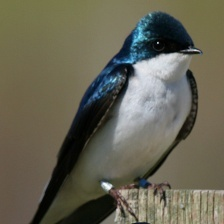

In [ ]:
# Tree Swallow sample image from the training dataset

# Read the image
tree_swallow = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/train/TREE SWALLOW/001.jpg')
# Print the image
print('Image shape:',tree_swallow.shape)
# Display the image
cv2_imshow(tree_swallow)

Image shape: (224, 224, 3)


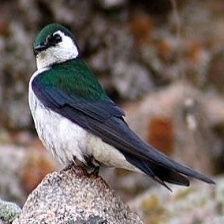

In [ ]:
# Violet Green Swallow sample image from the training dataset

# Read the image
violet_green_swallow = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/train/VIOLET GREEN SWALLOW/001.jpg')
# Print the image
print('Image shape:', violet_green_swallow.shape)
# Display the image
cv2_imshow(violet_green_swallow)

Image shape: (224, 224, 3)


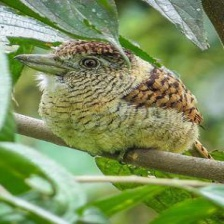

In [ ]:
# Barred Puffbird sample image from the training dataset

# Read the image
barred_puffbird = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/train/BARRED PUFFBIRD/001.jpg')
# Print the image
print('Image shape:', barred_puffbird.shape)
# Display the image
cv2_imshow(barred_puffbird)

Plot the distribution of images across the training dataset

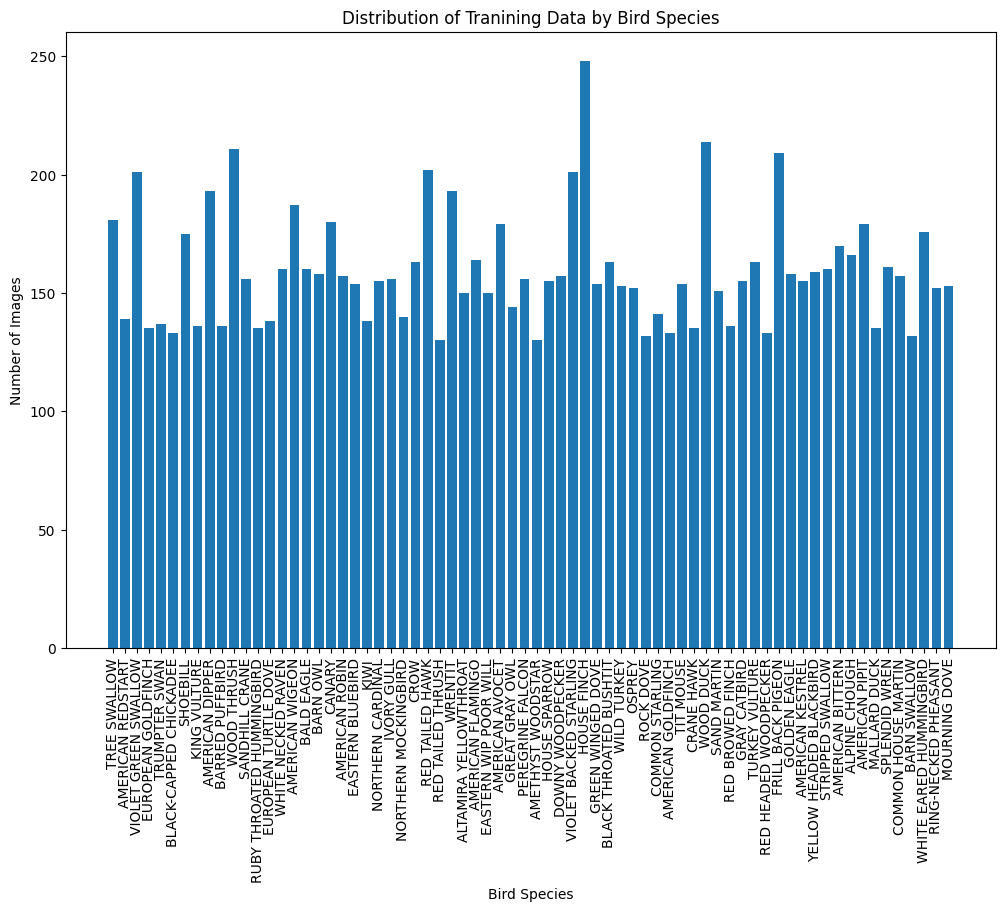

In [ ]:
# Determine the number of images within each folder (bird species) in the training dataset directory

# Set path for training dataset directory
train_folders = glob.glob('/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/train/*')
# Create a list (class_count), containing the same number of items as there are folders in the training dataset directory
class_count = [0] * len(train_folders)
# Create an empty list (labels) that will hold the class names
labels = []

# Enumerate through each folder within the training dataset directory
for i, folder in enumerate(train_folders):
  # Extract the class name from the folder
  class_name = os.path.basename(folder)
  # Append the class name to the labels list
  labels.append(class_name)
  # Count the number of files within the folder
  file_count = len(os.listdir(folder))
  # Assign the file count to the matching index in the class count list
  class_count[i] = file_count

# Plotting the bar chart

# Set the size of the bar chart
plt.figure(figsize=(12, 8))
plt.bar(labels, class_count)

# Turn labels 90 degrees so labels don't overlap
plt.xticks(rotation = 90)

plt.xlabel('Bird Species')
plt.ylabel('Number of Images')
plt.title('Distribution of Tranining Data by Bird Species')
# Save the plot as "bar_chart_training_data.png"
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/reports/bar_chart_training_data.png', bbox_inches = 'tight')
plt.show()

Search for the training folder with the least number of images

In [ ]:
# Find the bird species folder with the least number of images

# Set path for the training dataset directory
train_folder = '/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/train'
# Initialize the minimum number of images to positive infinity
min_images = float('inf')

# Iterate through each item in training folder directory
for folder in os.listdir(train_folder):
  # Creates a path for current item
  folder_path = os.path.join(train_folder, folder)
  # Checks that current item is a folder
  if os.path.isdir(folder_path):
    # Count the number of images within the current folder
    num_images = len(os.listdir(folder_path))
    # Check if current folder's "num_images" is less than "min_images"
    if num_images < min_images:
      #Update "min_image" with current folder's "num_images"
      min_images = num_images

print('Minimum number of images per folder:',min_images)

Minimum number of images per folder: 130


## Preprocess the data

In [ ]:
# Due to the dataset already being clean, and containing a training, testing, and validation set, little processing was needed
# It was found that using the original, 525 species dataset, was much too large for this project and caused a very long runtime that ended in disconnection
# Since Google Colab has limited runtime for users, a subset of the dataset was manually modified by deleting certain bird species, leaving 70 species
# The CSV file was also manually modified by removing unnecessary columns, including the scientific species name, leaving the CSV with 3 columns instead of 5
# Using only 70 species not only made the code run better, but it is also more realistic to use fewer species in this project due to it being based in a particular region of the world
# The original dataset is linked above, and a subset of the original dataset will be turned in as a zip file with the project for reference

## Prepare data for model usage

In [ ]:
# Data Augmentation

# Set hyperparameters
batch_size = 32
image_size = (224, 224)
validation_split = 0.2

# Define the path to the training data directory
train_path = '/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/train'

# Define data augmentation elements
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = validation_split
)

# Define data preprocessing elements for the validation data set
valid_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = validation_split
)

# Create flow from directory for the training set
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

# Create  flow from directory for the validation set
valid_set = valid_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 8956 images belonging to 70 classes.
Found 2208 images belonging to 70 classes.


# Model

## Define the model

In [ ]:
# Define the model
model = Sequential([
    # Convolutional layer
    Conv2D(16, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
    # Convolutional layer
    Conv2D(32, (3, 3), activation = 'relu'),
    # Pooling layer
    MaxPooling2D(2, 2),

    # Convolutional layer
    Conv2D(64, (3, 3), activation = 'relu'),
    # Convolutional layer
    Conv2D(128, (3, 3), activation = 'relu'),
    # Pooling layer
    MaxPooling2D(2, 2),

    # Flatten output
    Flatten(),

    # Fully connected layer with 128 nodes
    Dense(128, activation = 'relu'),
    # Dropout layer
    Dropout(0.2),
    #Output layer with 70 nodes (70 bird species)
    Dense(70, activation = 'softmax')
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# View summary of the model's structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                   

## Compile the model

In [ ]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Train and validate the model

Define callback methods

In [ ]:
# Define model checkpoint path to save the trained model
checkpoint_path = '/content/drive/MyDrive/Colab_Notebooks/models/birds/trained_model.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1)

Train and validate model

In [ ]:
# Train and validate the model (7 epochs)
history = model.fit(
    train_set,
    epochs = 7,
    validation_data = valid_set,
    callbacks = [model_checkpoint])

Epoch 1/7
280/280 [==============================] - ETA: 0s - loss: 3.9973 - accuracy: 0.0711
Epoch 1: val_accuracy improved from -inf to 0.13949, saving model to /content/drive/MyDrive/Colab_Notebooks/models/birds/trained_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 1590s 6s/step - loss: 3.9973 - accuracy: 0.0711 - val_loss: 3.5785 - val_accuracy: 0.1395
Epoch 2/7
280/280 [==============================] - ETA: 0s - loss: 3.4514 - accuracy: 0.1590
Epoch 2: val_accuracy improved from 0.13949 to 0.25317, saving model to /content/drive/MyDrive/Colab_Notebooks/models/birds/trained_model.h5
280/280 [==============================] - 1606s 6s/step - loss: 3.4514 - accuracy: 0.1590 - val_loss: 3.0324 - val_accuracy: 0.2532
Epoch 3/7
280/280 [==============================] - ETA: 0s - loss: 3.0271 - accuracy: 0.2364
Epoch 3: val_accuracy improved from 0.25317 to 0.33243, saving model to /content/drive/MyDrive/Colab_Notebooks/models/birds/trained_model.h5
280/280 [==============================] - 1612s 6s/step - loss: 3.0271 - accuracy: 0.2364 - val_loss: 2.7156 - val_accuracy: 0.3324
Epoch 4/7
280/280 [==============================] - ETA: 0s - loss: 2.7574 - accuracy: 0.2963
Epoch 4: val_accuracy improved fro

Plot model's training history

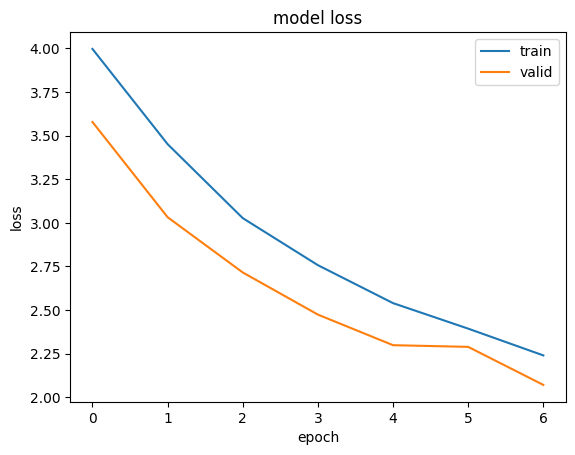

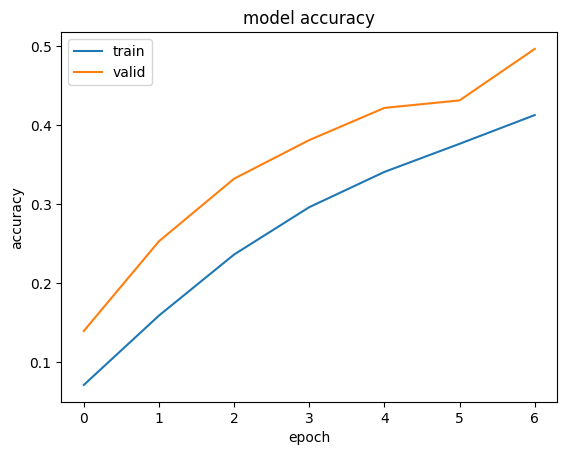

In [ ]:
# Model loss
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# Save the plot as "loss_plot_data.png"
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/reports/loss_plot_data.png', bbox_inches = 'tight')
plt.show()

# Model accuracy
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# Save the plot as "accuracy_plot_data.png"
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/reports/accuracy_plot_data.png', bbox_inches = 'tight')
plt.show()

# Testing the model

Test the model

In [ ]:
# Load the trained model
model = load_model('/content/drive/MyDrive/Colab_Notebooks/models/birds/trained_model.h5')

# Define the path to the raw testing data directory
test_path = '/content/drive/MyDrive/Colab_Notebooks/data/birds/raw/test'

# Define data preprocessing elements for testing set
test_datagen = ImageDataGenerator(rescale = 1.0/255)

# Define flow from directory for testing set
test_set = test_datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False)

# Evaluate the trained model compared with the test data
test_loss, test_acc = model.evaluate(test_set)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Found 350 images belonging to 70 classes.
350/350 [==============================] - 94s 268ms/step - loss: 3.6981 - accuracy: 0.4343
Test loss: 3.698129892349243
Test accuracy: 0.4342857003211975


Plot confusion matrix

350/350 [==============================] - 24s 68ms/step


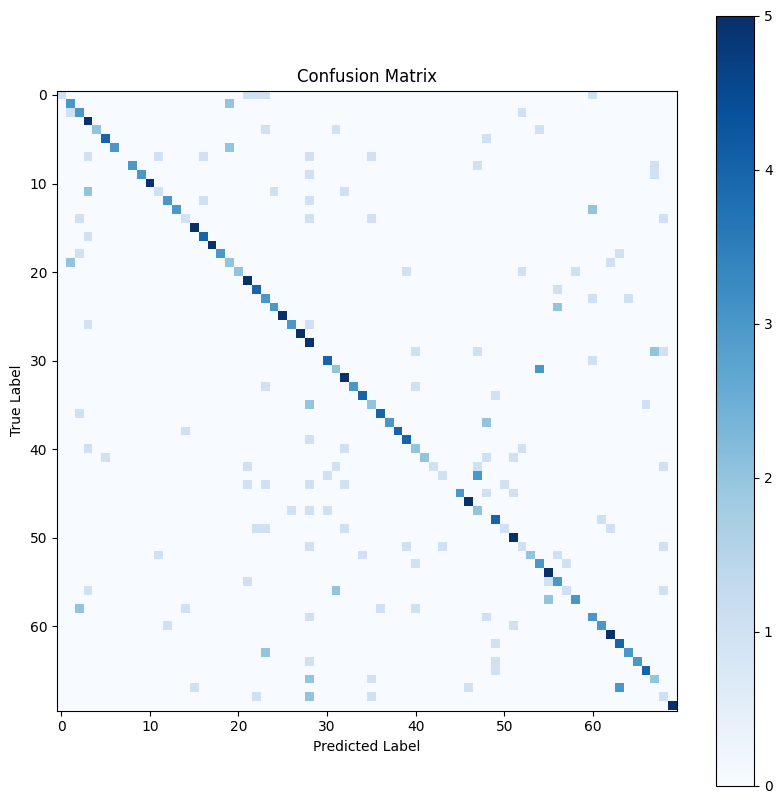

In [ ]:
# Plot the confusion matrix

# Use the trained model to make predictions on the testing data
y_pred = model.predict(test_set)
y_pred_labels = np.argmax(y_pred, axis = 1)
true_labels = test_set.classes

# Create the confusion matrix by using true and predicted labels
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize = (10, 10))
plt.imshow(conf_matrix, cmap = plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Save the confusion matrix as "confusion_matrix_data.png"
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/reports/confusion_matrix_data.png', bbox_inches = 'tight')
plt.show()

# API

Load and compile the trained model

In [ ]:
# Load the trained model
model = load_model('/content/drive/MyDrive/Colab_Notebooks/models/birds/trained_model.h5')

# Compile the model
model.compile(optimizer= 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Load the CSV file with metadata

In [ ]:
# Define the path to the CSV file with metadata
csv_path = '/content/drive/MyDrive/Colab_Notebooks/data/birds/birds.csv'

# Load the CSV file with metadata
metadata = pd.read_csv(csv_path)

Build and launch with Gradio

In [ ]:
# Define class names (bird species)
class_names = metadata['labels'].unique()
print('Class names:', class_names)

# Define the prediction method
def predict_species(image):
  image = image.reshape((-1, 224, 224, 3))
  prediction = model.predict(image)[0]
  return {class_names[i]: float(prediction[i]) for i in range(70)}

# Build the interface including sample images of bird species to choose from
interface = gr.Interface(
    fn = predict_species,
    inputs = gr.Image(shape = (224, 224)),
    outputs = gr.Label(num_top_classes = 5),
    examples = ['/content/drive/MyDrive/Colab_Notebooks/Ruby_Throated_Hummingbird.jpg', '/content/drive/MyDrive/Colab_Notebooks/Northern_Cardinal.jpg', '/content/drive/MyDrive/Colab_Notebooks/Bald_Eagle.jpg', '/content/drive/MyDrive/Colab_Notebooks/Canary.jpg', '/content/drive/MyDrive/Colab_Notebooks/Tree_Swallow.jpg', '/content/drive/MyDrive/Colab_Notebooks/Barn_Owl.jpg'],
    title = "Bird Species Classification",
    description = "Machine Learning Bird Species Classification",
    theme = "default"
)

# Launch the Gradio app
interface.launch(debug = True, share = True)

Class names: ['ALPINE CHOUGH' 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET'
 'AMERICAN BITTERN' 'AMERICAN FLAMINGO' 'AMERICAN GOLDFINCH'
 'AMERICAN KESTREL' 'AMERICAN PIPIT' 'AMERICAN REDSTART' 'AMERICAN ROBIN'
 'AMERICAN WIGEON' 'AMETHYST WOODSTAR' 'BALD EAGLE' 'BARN OWL'
 'BARN SWALLOW' 'BARRED PUFFBIRD' 'BLACK THROATED BUSHTIT'
 'BLACK-CAPPED CHICKADEE' 'CANARY' 'COMMON HOUSE MARTIN' 'COMMON STARLING'
 'CRANE HAWK' 'CROW' 'DOWNY WOODPECKER' 'EASTERN BLUEBIRD'
 'EASTERN WIP POOR WILL' 'EUROPEAN GOLDFINCH' 'EUROPEAN TURTLE DOVE'
 'FRILL BACK PIGEON' 'GOLDEN EAGLE' 'GRAY CATBIRD' 'GREAT GRAY OWL'
 'GREEN WINGED DOVE' 'HOUSE FINCH' 'HOUSE SPARROW' 'IVORY GULL'
 'KING VULTURE' 'KIWI' 'MALLARD DUCK' 'MOURNING DOVE' 'NORTHERN CARDINAL'
 'NORTHERN MOCKINGBIRD' 'OSPREY' 'PEREGRINE FALCON' 'RED BROWED FINCH'
 'RED HEADED WOODPECKER' 'RED TAILED HAWK' 'RED TAILED THRUSH'
 'RING-NECKED PHEASANT' 'ROCK DOVE' 'RUBY THROATED HUMMINGBIRD'
 'SAND MARTIN' 'SANDHILL CRANE' 'SHOEBILL' 'SPLENDID WREN'
 'STR

1/1 [==============================] - 0s 87ms/step


# Reports

Bar chart (Images Per Bird Species)

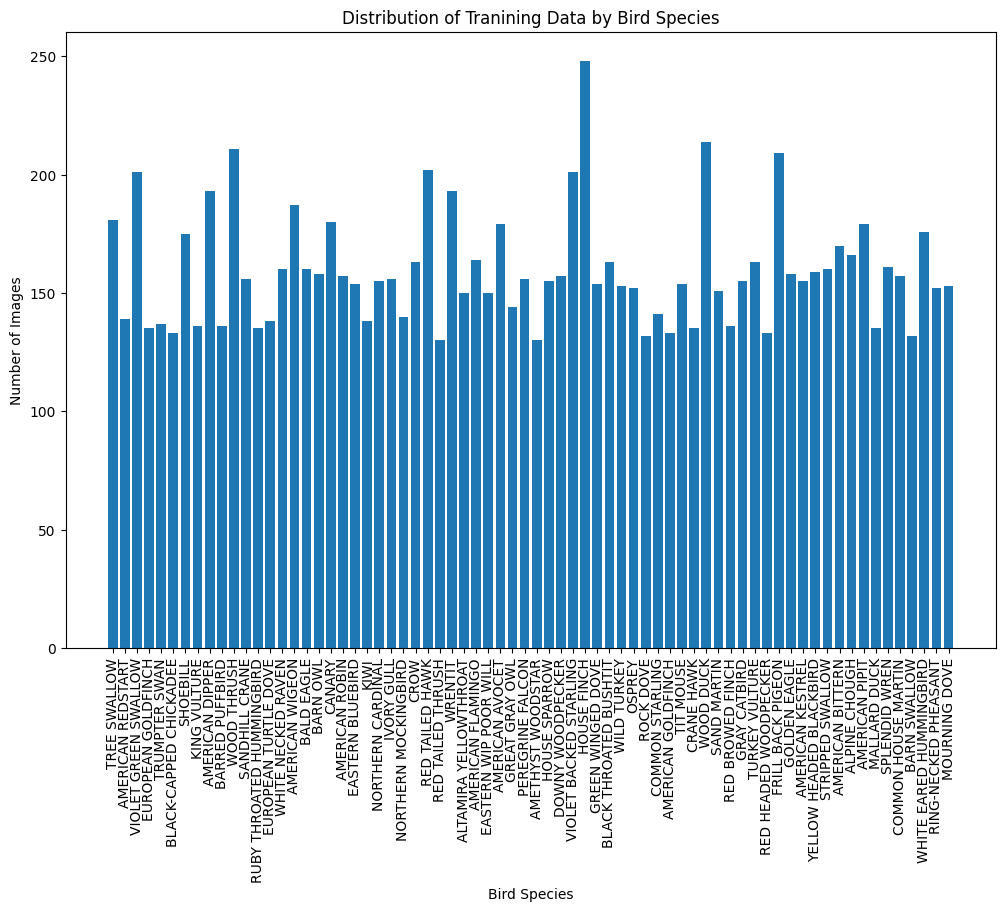

Plot (Model Training History)

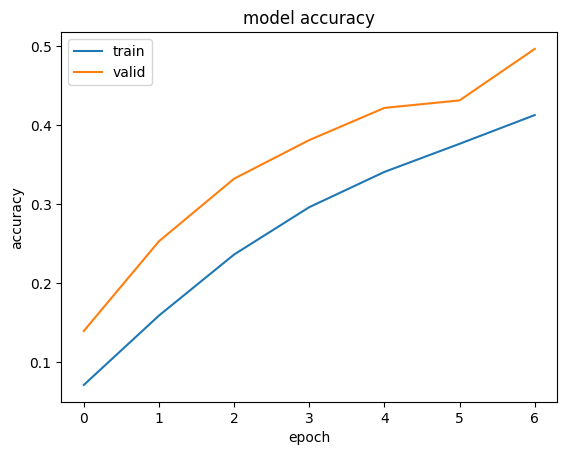

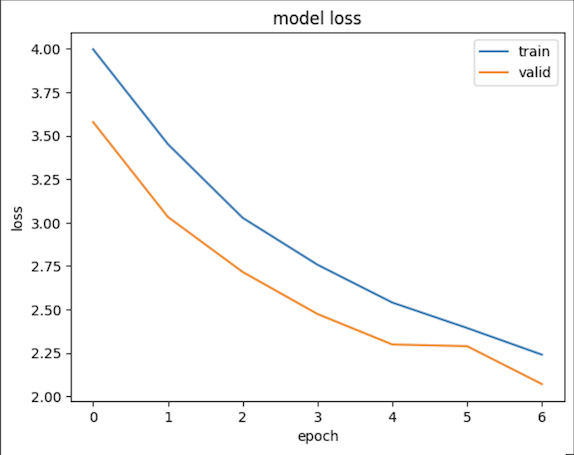

Confusion Matrix (Model Accuracy)

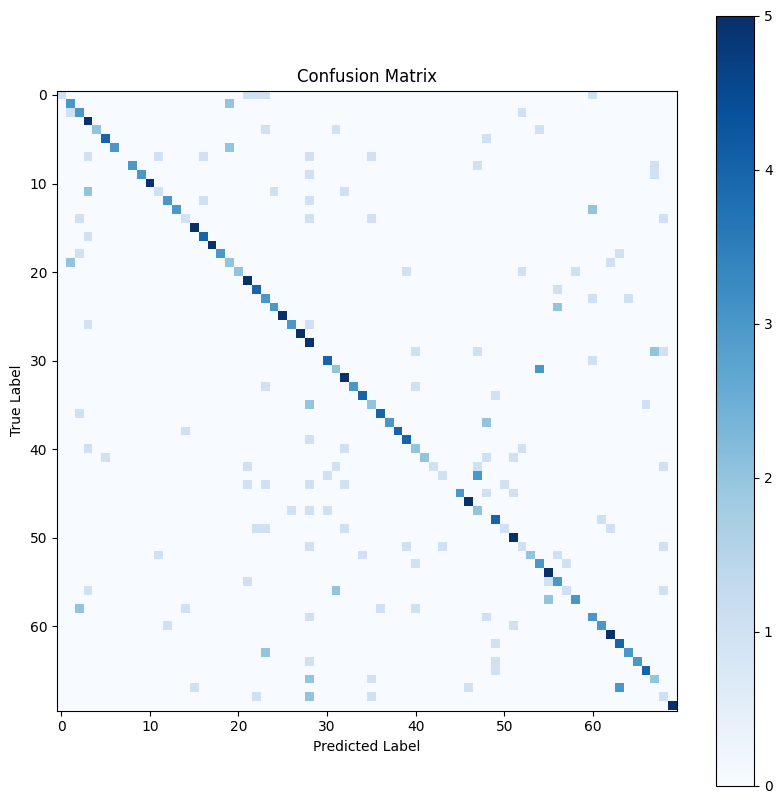